In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from queue import PriorityQueue

In [2]:
import os, math
from tqdm import tqdm       # pip install tqdm
import numpy as np

In [3]:
####### Rule #######

delta = 2

def compare(c1,c2):
    if c1==c2:
        return 0    # match
    if c1=='-' or c2=='-':
        return delta
    return 3        # mismatch

def comparelist(cs):
    # cyclic compare
    res = 0
    for i in range(len(cs)):
        for j in range(i+1,len(cs)):
            res += compare(cs[i],cs[j])
    return res

####### Data Preprocessing #######

curdir = ""

with open(curdir + "MSA_query.txt") as qf:
    queries = qf.read()
    pqs = queries[queries.find('2\n')+len('2\n'):queries.find('3\n')].splitlines()
    mqs = queries[queries.find('3\n')+len('3\n'):].splitlines()

with open(curdir + "MSA_database.txt") as df:
    targets = df.read().splitlines()


244
['IW-TJB---GTJ-GJTW-G--B---JTPKHAXHA--GJJSJJPPJAPJHJHJHJHJHJHJHJ-----HJPKSTJJUWXHGP--HGALKLPJTPJPGVXPLBJ--H----HJPKWPPDJSG', 'IBLTWLIAXGWWWGK-WPGWWBLAOJG---AXGLOTGLJTWLXBJOQUXGOTHGXXXWOWXXMOXOPHAPPPPHAPPPHAPPPH-A---P--P-PHAATAHAAAHKXMAHA-KTOHZYLP']
244.0
['I---W-TJBG-TJGJTW-G--B---JTPKHAX--HAG-J---JSJJPPJAPJH-JHJHJHJHJHJHJHJPKSTJJUWXH--GPHGALKLPJTPJPGVXP--LBJH---H----JPKWPPDJSG', 'IBLTWLIAXGWWWGK-WPGWWBLAOJG---AXGLOTGLJTWLXBJOQUXGOTHGXXXWOWXXMOXOPHAPPPP-----HAPPPH-APP-PHAP-P---PHAATAHAAAHKXMAHAKTOHZYLP']


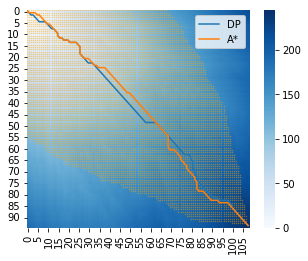

In [4]:
# DP

def decodeMove(m:np.uint8,dim):
    return tuple(1 if m & (2**v) > 0 else 0 for v in range(dim))

def editDistanceDP(S,dist:np.array=np.array([]),move:np.array=np.array([])):
    L = len(S)
    if L == 0:
        return np.array([0]), np.array([0])
    global fdim
    if len(dist)==0:
        # initialize dist and move
        shape = tuple(len(S[l])+1 for l in range(L))
        dist = np.ones(shape=shape, dtype=np.int32)
        dist = -1 * dist        # negative means no data
        move = np.zeros(shape=shape, dtype=np.uint8)
        fdim = L
    # calculate the lower dimension (edges)
    for s in range(L):
        slicer = tuple(0 if i==s else slice(None) for i in range(L)) # slice(None) stands for : symbol
        dist[slicer], move[slicer] = editDistanceDP(S[0:s]+S[s+1:L], dist[slicer], move[slicer]) # skip S[s]
        # configure move, insert 0 in the corresponding bit
        # Example: 4-dim xyzw xyw cube z(2) = 0, get an move 111(wyx), but with that be zero, it should be 1011.
        # REMEMBER to place the right end in the same level!
        move[slicer] = (move[slicer] >> s << (s+1)) + (move[slicer] & (2**s-1))
    # Spread the remaining space, since the edge case has been considered, the remaining space will have the same action set.
    it = np.nditer(dist, flags=['multi_index'], op_flags=["readwrite"])
    while not it.finished:
        pos = it.multi_index
        if 0 in pos:
            it.iternext()
            continue    # calculated
        ## The range of available move is 1~(2^L-1)
        minmove = np.uint8(0)
        minvalue = np.inf
        for m in range(1,2**L):
            move_vec = decodeMove(m,L)
            prev_pos = tuple(a-b for a,b in zip(pos,move_vec))
            penalty = comparelist([S[a][p] if move_vec[a]==1 else "-" for a,p in enumerate(prev_pos)]+["-" for i in range(fdim - L)])  # the term is required since the higher dim will be gapped.
            moved_dist = dist[prev_pos] + penalty
            if moved_dist < minvalue:
                minmove = m
                minvalue = moved_dist
        it[0] = minvalue
        move[pos] = minmove
        it.iternext()
    return dist, move

def alignmentDP(S):
    dist, move = editDistanceDP(S)
    sns.heatmap(dist,cmap='Blues')

    path = []
    pos = tuple(len(s) for s in S)
    cost = dist[pos]
    start = tuple(0 for i in range(len(S)))
    xaxis = [pos[0]]
    yaxis = [pos[1]]
    while not pos == start:
        prev_move = decodeMove(move[pos],len(S))
        path.insert(0,prev_move)
        pos = tuple(a-b for a,b in zip(pos,prev_move))
        xaxis.insert(0,pos[0])
        yaxis.insert(0,pos[1])
    plt.plot(yaxis,xaxis,label='DP')

    S_ = ["" for i in range(len(S))]
    S_ptr = [0 for i in range(len(S))]
    for path_move in path:
        for axis,axis_move in enumerate(path_move):
            if axis_move==0:
                S_[axis] += "-"
            else:
                S_[axis] += S[axis][S_ptr[axis]]
                S_ptr[axis] += 1
    print(cost)
    return S_

# A-Star

def decodeMove(m:np.uint8,L):
    # zyx
    return tuple(1 if m & (2**v) > 0 else 0 for v in range(L))

def editDistanceASTAR(S):
    L = len(S)

    # To shift the string starting from 1
    S = ["-"+S[i] for i in range(L)]

    def h(pos:tuple):
        """
        heuristic function
        """
        a = [len(S[i])-pos[i] for i in range(L)]
        return delta * (L*max(a)-sum(a))

    # initialize dist and move and openSet
    shape = tuple(len(S[l]) for l in range(L))
    dist = np.ones(shape=shape, dtype=np.int32)
    dist = np.inf * dist        # negative means no data
    move = np.zeros(shape=shape, dtype=np.uint8)
    openSet = PriorityQueue()

    # put Start in the queue
    start = tuple(0 for l in range(L))
    dist[start] = 0
    move[start] = 0
    openSet.put((h(start),start))

    finish = tuple(len(S[l])-1 for l in range(L))
    closeSet = set()

    while not openSet.empty():
        current = openSet.get()[1]
        if current == finish:
            x,y = zip(*closeSet) #
            plt.scatter(y,x,alpha=0.5,c=["orange"],s=0.2) #
            return dist, move
        
        closeSet.add(current)
        for m in range(1,2**L):
            move_vec = decodeMove(m,L)
            neighbor = tuple(a+b for a,b in zip(current, move_vec))
            if True in tuple(neighbor[l]>=len(S[l]) for l in range(L)):
                continue    # unavaliable move
            g = dist[current] + comparelist([S[a][p] if move_vec[a]==1 else "-" for a,p in enumerate(neighbor)])
            if g < dist[neighbor]:
                move[neighbor] = m
                dist[neighbor] = g
                if neighbor not in closeSet:
                    openSet.put((g + h(neighbor),neighbor))

    raise Exception("unreachable.")
    
def alignmentASTAR(S):
    L = len(S)
    dist, move = editDistanceASTAR(S)

    path = []
    pos = tuple(len(s) for s in S)
    cost = dist[pos]
    start = tuple(0 for i in range(L))
    xaxis = [pos[0]] #
    yaxis = [pos[1]] #
    while not pos == start:
        prev_move = decodeMove(move[pos],L)
        path.insert(0,prev_move)
        pos = tuple(a-b for a,b in zip(pos,prev_move))
        xaxis.insert(0,pos[0]) #
        yaxis.insert(0,pos[1]) #
    plt.plot(yaxis,xaxis,label='A*') #

    S_ = ["" for i in range(L)]
    S_ptr = [0 for i in range(L)]
    for path_move in path:
        for axis,axis_move in enumerate(path_move):
            if axis_move==0:
                S_[axis] += "-"
            else:
                S_[axis] += S[axis][S_ptr[axis]]
                S_ptr[axis] += 1
    print(cost)
    return S_

def test(TestCase):
    plt.figure(figsize=(5,4))
    print(alignmentDP(TestCase))
    print(alignmentASTAR(TestCase))
    plt.legend(loc='upper right')
    plt.savefig('img/path.jpg',dpi=200)
    plt.show()

test(["IWTJBGTJGJTWGBJTPKHAXHAGJJSJJPPJAPJHJHJHJHJHJHJHJHJPKSTJJUWXHGPHGALKLPJTPJPGVXPLBJHHJPKWPPDJSG",
"IBLTWLIAXGWWWGKWPGWWBLAOJGAXGLOTGLJTWLXBJOQUXGOTHGXXXWOWXXMOXOPHAPPPPHAPPPHAPPPHAPPPHAATAHAAAHKXMAHAKTOHZYLP"])